In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

#the above imports the plotting library matplotlib

In [11]:
#other useful imports we've seen before

import h5py
import numpy as np
import math
import os
import scipy.stats as stats

In [12]:
#ok let's load the data mb
DATA_PATH = "/mnt/data3/yamins/visual/ventral_neural_data.hdf5"
Ventral_Dataset = h5py.File(DATA_PATH, mode='r')

In [13]:
all_images = Ventral_Dataset['images']
all_images.dims.keys()

[<"image" dimension 0 of HDF5 dataset at 140065809160144>,
 <"height" dimension 1 of HDF5 dataset at 140065809160144>,
 <"width" dimension 2 of HDF5 dataset at 140065809160144>]

In [14]:
image_meta = Ventral_Dataset['image_meta']
categories = image_meta['category'][:]

## Single-feature classifiers

### faces vs cars

In [15]:
#get the features (the independent variables)
Neural_Data = Ventral_Dataset['time_averaged_trial_averaged'][:]

In [257]:
Neural_Data.shape

(5760, 296)

In [254]:
Neural_Data[:, 0]

(5760,)

In [16]:
#get the labels (the dependent variables)
face_or_not = (categories == 'Faces')
face_inds = face_or_not.nonzero()[0]
car_or_not = (categories == 'Cars')
car_inds = car_or_not.nonzero()[0]

face_or_car = ((categories == 'Faces') | (categories == 'Cars'))
categories_face_or_car = categories[face_or_car]
face_not_car = (categories_face_or_car == 'Faces')
Neural_Data_subset = Neural_Data[face_or_car]

In [253]:
categories_face_or_car

array(['Cars', 'Cars', 'Cars', ..., 'Cars', 'Cars', 'Cars'], dtype='|S7')

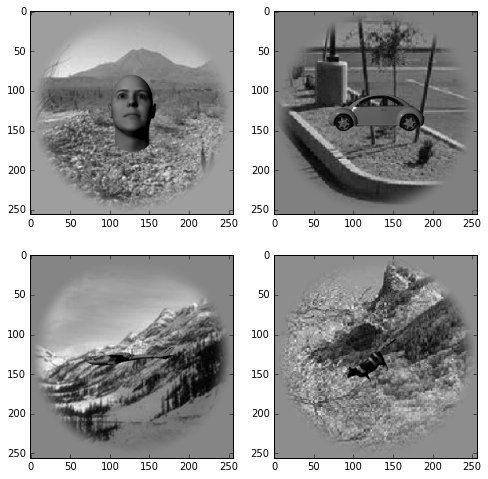

In [17]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.imshow(all_images[face_inds[0]], cmap='gray')

plt.subplot(2, 2, 2)
plt.imshow(all_images[car_inds[0]], cmap='gray')

plt.subplot(2, 2, 3)
plt.imshow(all_images[244], cmap='gray')

plt.subplot(2, 2, 4)
plt.imshow(all_images[2144], cmap='gray')

In [255]:
face_not_car

array([False, False, False, ..., False, False, False])

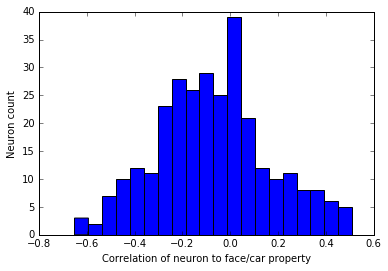

In [18]:
corr_facevscar = np.array([stats.pearsonr(Neural_Data_subset[:, i], 
                                          face_not_car)[0] 
                             for i in range(Neural_Data_subset.shape[1])])

plt.hist(corr_facevscar, bins=20)
plt.xlabel('Correlation of neuron to face/car property')
plt.ylabel('Neuron count')

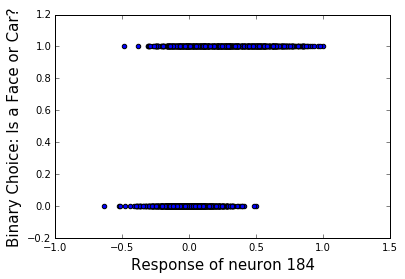

In [214]:
neurons_sorted_by_facevscar_correlation = corr_facevscar.argsort()
best_ind_facevscar = neurons_sorted_by_facevscar_correlation[-1]
most_corred_resp_faceorcar = Neural_Data_subset[:, best_ind_facevscar]

plt.scatter(most_corred_resp_faceorcar, face_not_car)
plt.xlabel('Response of neuron %d' % best_ind_facevscar, fontsize=15)
plt.ylabel('Binary Choice: Is a Face or Car?', fontsize=15)

In [215]:
def hist_plot(resp, target_inds, target, nottarget):
    responses_on_target = resp[target_inds]
    responses_on_nottarget = resp[np.invert(target_inds)]
    l0 = plt.hist(responses_on_target, bins=20);
    l1 = plt.hist(responses_on_nottarget, bins=20, alpha=0.5);
    plt.legend([l0[2][0], l1[2][0]], [target, nottarget])
    plt.xlabel('neuron response value', fontsize=15)
    plt.ylabel('normalized image count', fontsize=15)

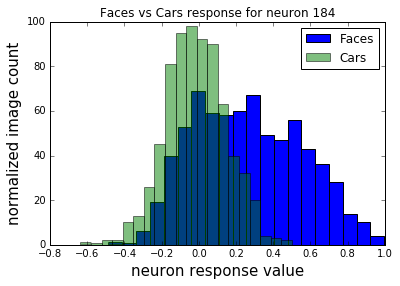

In [216]:
#Again, let's look at our best neuron
hist_plot(most_corred_resp_faceorcar, face_not_car, 'Faces', 'Cars')
plt.title('Faces vs Cars response for neuron %d' % best_ind_facevscar)

#now the distribution is much more skewed obviously
#but the best neuron for the just is still the same actually

In [217]:
def plot_threshold_acc(resp, categories, target, chance_level, 
                       xoffset=.1, yoffset=.1, yoffset_chance=.1):
    threshold_series = np.arange(-3, 3, .01)
    pcs = [fraction_correct(resp > t, categories) 
                        for t in threshold_series]
    best_thres_ind = np.argmax(pcs)
    best_thres = threshold_series[best_thres_ind]
    best_acc = pcs[best_thres_ind]
    plt.plot(threshold_series, pcs)
    plt.axvline(best_thres, color='k')
    plt.xlabel('Threshold', fontsize=15)
    plt.ylabel('Accuracy on %s detection' % target, fontsize=15)
    plt.annotate('best accuracy (%.2f%%)\nat thres=%.3f' % (best_acc * 100, best_thres),
                 xy=(best_thres, best_acc), 
                 xytext=(best_thres + xoffset, best_acc + yoffset),
                arrowprops=dict(facecolor='black', shrink=0.05),
                )
    
    plt.axhline(chance_level, color='k')
    plt.annotate('Chance = %.3f' % chance_level, xy=(-2, chance_level), 
                 xytext=(-2, chance_level + yoffset_chance), 
                 arrowprops=dict(facecolor='black', shrink=0.05))

    return best_thres

In [218]:
#this is a generic function computing correctness for a
#prediction vs an actual.  This assumes the predictions are binary 
#(either 0  or 1)

def fraction_correct(predicted, actual):
    #get number of trials where predicted equals actual
    correct = (predicted == actual).sum()  
    #get total number of trials
    total = len(actual)
    #get fraction correct
    frac = correct / float(total)
    return frac

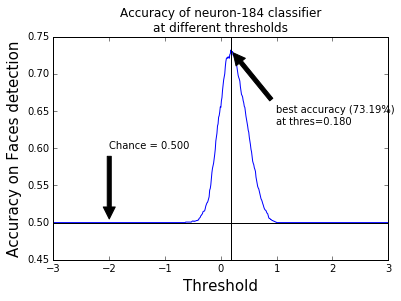

In [219]:
best_threshold_faceorcar = plot_threshold_acc(most_corred_resp_faceorcar, face_not_car, 'Faces', 0.5, 
                   xoffset=.8, yoffset=-.1)
plt.title('Accuracy of neuron-%d classifier\nat different thresholds' % best_ind_facevscar)

In [92]:
raw_predictions = (most_corred_resp_faceorcar > best_threshold_faceorcar)

In [93]:
raw_predictions

array([False, False, False, ..., False, False, False])

In [94]:
predictions_facevscar_bestsingle = np.where(raw_predictions, 
                                            'Faces', 'Cars')

In [95]:
predictions_facevscar_bestsingle

array(['Cars', 'Cars', 'Cars', ..., 'Cars', 'Cars', 'Cars'], dtype='|S5')

In [96]:
categories_face_or_car

array(['Cars', 'Cars', 'Cars', ..., 'Cars', 'Cars', 'Cars'], dtype='|S7')

In [259]:
(categories_face_or_car == predictions_facevscar_bestsingle).sum() / float(len(predictions_facevscar_bestsingle))

0.7319444444444444

In [97]:
def get_confusion_matrix(predicted, actual, ucats):
    """Gets confusion matrix where 
           mat[i, j] = number of instances where 
                 actual = category i and 
                 predicted = category j
    """
    cmat = []
    for a_cat in ucats:
        cvec = []
        for p_cat in ucats:
            rate = ((predicted == p_cat) & (actual == a_cat)).sum()
            cvec.append(rate)
        cmat.append(cvec)
    return np.array(cmat)

def visualize_confmat(cmat, ucats, fig=None):
    cmat = cmat.astype(float) / cmat.sum(0)
    if fig is None:
        plt.matshow(cmat)
    else:
        fig.gca().matshow(cmat)
    for i in range(cmat.shape[0]):
        for j in range(cmat.shape[1]):
            plt.text(j-.1, i, '%.2f%%' % (cmat[i, j] * 100), color='w')
    M = len(ucats)
    plt.xticks(np.arange(M), ucats)
    plt.yticks(np.arange(M), ucats)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

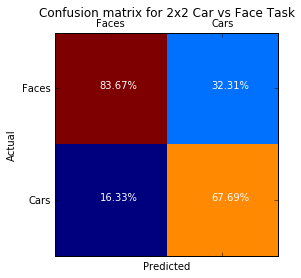

In [112]:
cmat_facevscar_bestsingle = get_confusion_matrix(predictions_facevscar_bestsingle, 
                                                 categories_face_or_car, 
                                                 ['Faces', 'Cars'])
visualize_confmat(cmat_facevscar_bestsingle, ['Faces', 'Cars'])
plt.title('Confusion matrix for 2x2 Car vs Face Task')

#Upper right: True Positives
#Lower Right: True Negatives
#Upper Left: False Negatives
#Lower Left: False Positives

### most *absolutely*-correlated feature

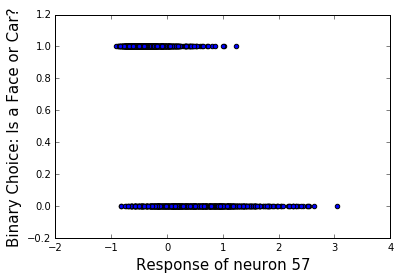

In [220]:
neurons_sorted_by_facevscar_abscorrelation = np.abs(corr_facevscar).argsort()
best_ind_facevscar = neurons_sorted_by_facevscar_abscorrelation[-1]
most_abscorred_resp_faceorcar = Neural_Data_subset[:, best_ind_facevscar]

plt.scatter(most_abscorred_resp_faceorcar, face_not_car)
plt.xlabel('Response of neuron %d' % best_ind_facevscar, fontsize=15)
plt.ylabel('Binary Choice: Is a Face or Car?', fontsize=15)

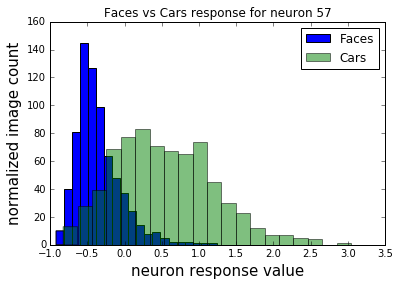

In [221]:
#Again, let's look at our best neuron
hist_plot(most_abscorred_resp_faceorcar, face_not_car, 'Faces', 'Cars')
plt.title('Faces vs Cars response for neuron %d' % best_ind_facevscar)

#now the distribution is much more skewed obviously
#but the best neuron for the just is still the same actually

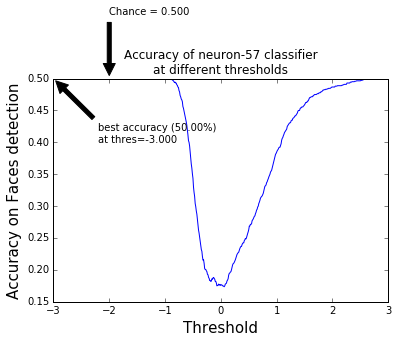

In [29]:
plot_threshold_acc(most_abscorred_resp_faceorcar, face_not_car, 'Faces', 0.5, 
                   xoffset=.8, yoffset=-.1)
plt.title('Accuracy of neuron-%d classifier\nat different thresholds' % best_ind_facevscar)

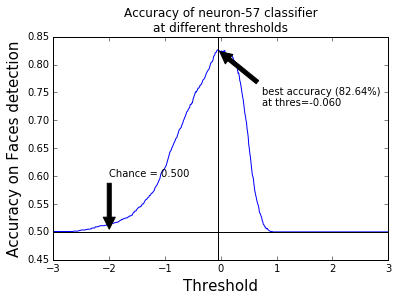

In [99]:
weight = -1
best_threshold_abs = plot_threshold_acc(weight*most_abscorred_resp_faceorcar, face_not_car, 'Faces', 0.5, 
                   xoffset=.8, yoffset=-.1)
plt.title('Accuracy of neuron-%d classifier\nat different thresholds' % best_ind_facevscar)

In [210]:
raw_predictions = (most_abscorred_resp_faceorcar > best_threshold_abs)
predictions_facevscar_bestabssingle_wrong = np.where(raw_predictions, 'Faces', 'Cars')

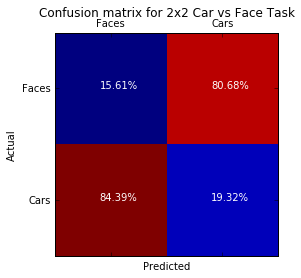

In [211]:
cmat_facevscar_bestabssingle = get_confusion_matrix(predictions_facevscar_bestabssingle_wrong, 
                                                    categories_face_or_car, 
                                                    ['Faces', 'Cars'])
visualize_confmat(cmat_facevscar_bestabssingle, ['Faces', 'Cars'])
plt.title('Confusion matrix for 2x2 Car vs Face Task')

#Upper right: True Positives
#Lower Right: True Negatives
#Upper Left: False Negatives
#Lower Left: False Positives

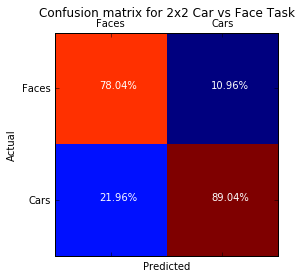

In [237]:
raw_predictions = (weight * most_abscorred_resp_faceorcar > best_threshold_abs)
predictions_facevscar_bestabssingle = np.where(raw_predictions, 'Faces', 'Cars')

cmat_facevscar_bestabssingle = get_confusion_matrix(predictions_facevscar_bestabssingle, 
                            categories_face_or_car, 
                            ['Faces', 'Cars'])
visualize_confmat(cmat, ['Faces', 'Cars'])
plt.title('Confusion matrix for 2x2 Car vs Face Task')

#Upper right: True Positives
#Lower Right: True Negatives
#Upper Left: False Negatives
#Lower Left: False Positives

### Faces vs Not-faces

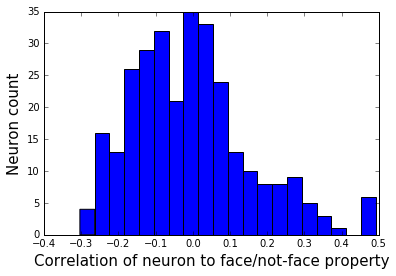

In [226]:
corr_facevsnot = np.array([stats.pearsonr(Neural_Data[:, i], 
                                          face_or_not)[0] 
                             for i in range(Neural_Data.shape[1])])

plt.hist(corr_facevsnot, bins=20)
plt.xlabel('Correlation of neuron to face/not-face property', fontsize=15)
plt.ylabel('Neuron count', fontsize=15)

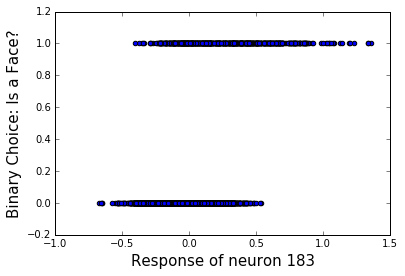

In [227]:
neurons_sorted_by_facevsnot_abscorrelation = np.abs(corr_facevsnot).argsort()
best_ind_facevsnot = neurons_sorted_by_facevsnot_abscorrelation[-1]
most_abscorred_resp_faceornot = Neural_Data[:, best_ind_facevsnot]

plt.scatter(most_abscorred_resp_faceornot, face_or_not)
plt.xlabel('Response of neuron %d' % best_ind_facevsnot, fontsize=15)
plt.ylabel('Binary Choice: Is a Face?', fontsize=15)

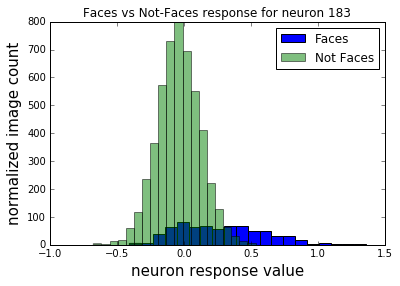

In [228]:
#Again, let's look at our best neuron
hist_plot(most_abscorred_resp_faceornot, face_or_not, 'Faces', 'Not Faces')
plt.title('Faces vs Not-Faces response for neuron %d' % best_ind_facevsnot)

#now the distribution is much more skewed obviously
#but the best neuron for the just is still the same actually

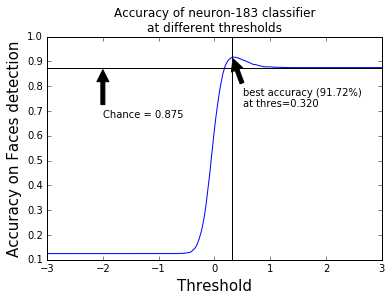

In [229]:
best_threshold_facevsnot_abs = plot_threshold_acc(most_abscorred_resp_faceornot, face_or_not, 'Faces', 7/8.,
                   xoffset=.2, yoffset=-.2, yoffset_chance=-.2)
plt.title('Accuracy of neuron-%d classifier\nat different thresholds' % best_ind_facevsnot)

#hm -- couple of things
#  (1) the best threshold is no longer the middle between the means
#  (2) the level of chance is much higher now, so the raw performance is not that meaningful

In [275]:
raw_predictions_facevsnot_bestabssingle = most_abscorred_resp_faceornot > best_threshold_facevsnot_abs
predictions_facevsnot_bestabssingle = np.where(raw_predictions_facevsnot_bestabssingle, 'Faces', 'Not-Faces')

In [231]:
actual_facevsnot = np.where(categories == 'Faces', 'Faces', 'Not-Faces')

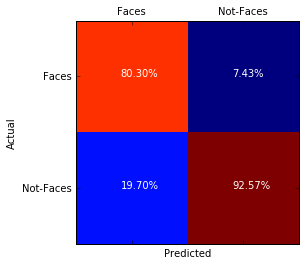

In [235]:
cmat_facevsnot_bestabssingle = get_confusion_matrix(predictions_facevsnot_bestabssingle, 
                                                    actual_facevsnot,
                                                    ['Faces', 'Not-Faces'])
visualize_confmat(cmat_facevsnot_bestabssingle, ['Faces', 'Not-Faces'])

#Upper right: True Positives
#Lower Right: True Negatives
#Upper Left: False Negatives
#Lower Left: False Positives

### d-prime

In [344]:
def dprime_from_rates(tpr, far, clip=5):
    """Computes the formula
          Z(true positive rate) - Z(false alarm rate)
        where Z = inverse of the CDF of the gaussian
    """
    posppf = np.clip(stats.norm.ppf(tpr), -clip, clip)
    negppf = np.clip(stats.norm.ppf(far), -clip, clip)
    return posppf - negppf


def dprime_binary(predicted, actual, clip=5):
    """Assumes predicted, actual binary (0, 1)-valued vectors -- 
       the positive class value is "1" while the negative class is "0"
    """
    total_positives = (actual == 1).sum()
    true_positives = ((predicted == 1) & (actual == 1)).sum()
    true_positive_rate = true_positives / float(total_positives)
    total_negatives = (actual == 0).sum()
    false_alarms = ((predicted == 1) & (actual == 0)).sum()
    false_alarm_rate = false_alarms / float(total_negatives)
    return dprime_from_rates(true_positive_rate, false_alarm_rate, clip=clip)


def confusion_matrix_stats(cmat):
    """get generalized statistics from confusion matrix
       arguments: confusion matrix of shape (M, M) where M = number of categories
                   rows are actual, columns are predicted
       returns:
          len-M vectors of 
            total positives (P)
            total negavites (N)
            true positives (TP)
            true negatives (TN)
            false positives (FP)
            false nevatives (FN)
    """
    M = cmat.shape[0]
    TP = []
    FN = []
    FP = []
    TN = []
    for i in range(M):
        tp = cmat[i, i]                  #true positives are the diagonal element
        fp = cmat[:, i].sum() - tp       #false positives are column sum - diagonal
        fn = cmat[i].sum() - tp          #false negatives are row sum - diagonal
        tn = cmat.sum() - fp - fn - tp   #true negatives are everything else
        TP.append(tp)
        FN.append(fn)
        FP.append(fp)
        TN.append(tn)
    TP = np.array(TP)
    FN = np.array(FN)
    FP = np.array(FP)
    TN = np.array(TN)
    P = TP + FN    #total positives are true positives + false negatives
    N = TN + FP    #total negatives are true negatives + false positives
    return P, N, TP, TN, FP, FN
    
    
def balanced_accuracy(confmat):
    """Computes balanced accuracy (see http://mvpa.blogspot.com/2015/12/balanced-accuracy-what-and-why.html)
       from confusion matrix 
    """
    P, N, TP, TN, FP, FN = confusion_matrix_stats(confmat)
    sensitivity = TP / P.astype(float)
    specificity = TN / N.astype(float)
    balanced_acc = (sensitivity + specificity) / 2.
    return balanced_acc


def f1_score(confmat):
    """Computes f1 score (see http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)
    """
    P, N, TP, TN, FP, FN = confusion_matrix_stats(confmat)
    precision = TP / (TP + FP).astype(float)
    recall = TP / (TP + FN).astype(float)
    f1_val = 2 * precision * recall / (precision + recall)
    return f1_val


def dprime_confmat(cmat, clip=5):
    """Computes vector of dprimes from confusion matrix
    """
    P, N, TP, TN, FP, FN = confusion_matrix_stats(cmat)
    TPR = TP / P.astype(float)
    FPR = FP / N.astype(float)
    return dprime_from_rates(TPR, FPR, clip=clip)


def accuracy_confmat(cmat):
    correct = cmat.diagonal().sum()
    total = cmat.sum()
    return correct / float(total)

In [266]:
ba_facevscar = balanced_accuracy(cmat_facevscar_bestabssingle)[0]
ba_facevsnot = balanced_accuracy(cmat_facevsnot_bestabssingle)[0]

print('Balanced accuracy for face-vs-car task: %.3f' % ba_facevscar )
print('Balanced accuracy for face-vs-not task: %.3f' % ba_facevsnot )

Balanced accuracy for face-vs-car task: 0.826
Balanced accuracy for face-vs-not task: 0.716


In [348]:
f1_facevscar = f1_score(cmat_facevscar_bestabssingle)[0]
f1_facevsnot = f1_score(cmat_facevsnot_bestabssingle)[0]

print('f1-score for face-vs-car task: %.3f' % ba_facevscar )
print('f1-score for face-vs-not task: %.3f' % ba_facevsnot )

f1-score for face-vs-car task: 0.826
f1-score for face-vs-not task: 0.716


In [267]:
dp_facevscar = dprime_confmat(cmat_facevscar_bestabssingle)[0]
dp_facevsnot = dprime_confmat(cmat_facevsnot_bestabssingle)[0]

print('Dprime for face-vs-car task: %.3f' % dp_facevscar )
print('Dprime for face-vs-not task: %.3f' % dp_facevsnot )

Dprime for face-vs-car task: 1.988
Dprime for face-vs-not task: 2.020


## Minimum Distance Classifiers

In [121]:
#ok So let's work with all 8 categories
unique_categories = np.unique(categories)                #array of unique category labels --> shape == (8,)


In [260]:
unique_categories

array(['Animals', 'Boats', 'Cars', 'Chairs', 'Faces', 'Fruits', 'Planes',
       'Tables'], dtype='|S7')

In [122]:
len(unique_categories)

8

In [123]:
#Now, the core idea of the minimum distance classifier is to 
#   look at distances to means of (neural) features for each category
#   so let's compute the neural feature means for the 8 categories here
category_means = np.array([Neural_Data[categories == c].mean(0)
                           for c in unique_categories])

In [124]:
#As expected, this is an array with shape (num_categories, num_neurons)
category_means.shape

(8, 296)

([<matplotlib.axis.YTick at 0x7f639806fc10>,
 <a list of 8 Text yticklabel objects>)

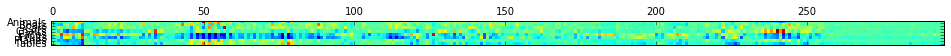

In [262]:
#let's visualize it
plt.matshow(category_means)
plt.yticks(range(8), unique_categories)

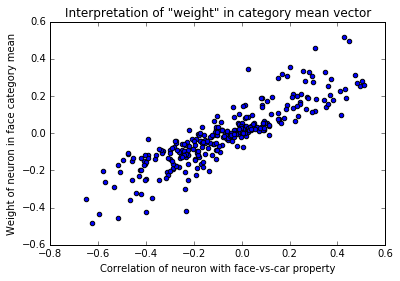

In [126]:
#actually we can interpret the relationship between these values
#and the single-neuron stuff we saw earlier .... 
plt.scatter(corr_facevscar, category_means[4])
plt.xlabel('Correlation of neuron with face-vs-car property')
plt.ylabel('Weight of neuron in face category mean')
plt.title('Interpretation of "weight" in category mean vector')

#the value of the average response for neuron i in category j is highly correlated
#with the per-neuron correlation to the j-vs-not-j property

In [127]:
#With this in mind, we can construct a simple euclidean-distance classifier

def distance_classifier(x, means, ucats):
    """Arguments:
         x = new example of data -- of shape N (where N = number of features)
         means = matrix of means of each feature for each category, 
                 of shape (M, N), where M = number of categories
         ucats = vector of category labels (of length M)
       Returns: prediction for x based on minimum distance to category means
    """
    #compute the distances between x and each mean
    distances = ((x - means)**2).sum(1)  #this is a length M vector
    #find the index of the category with the smallest distance
    predicted_category_ind = distances.argmin()    
    #get the category corresponding to that index
    predicted_category = ucats[predicted_category_ind]
    return predicted_category

In [261]:
unique_categories

array(['Animals', 'Boats', 'Cars', 'Chairs', 'Faces', 'Fruits', 'Planes',
       'Tables'], dtype='|S7')

In [128]:
#now let's apply this classifier to cars vs faces  

carface_category_means = category_means[[2, 4]]  #since Cars and Faces were the 2nd and 4th categories, respecitvely
predictions = []
#loop over the neural responses to each stimulus
for resp in Neural_Data_subset:
    #get the predictions for each stimulus
    pred = distance_classifier(resp, 
                               carface_category_means, 
                               ['Cars', 'Faces'])
    #add to the list of predictions
    predictions.append(pred)
#make it a numpy array
predictions_facevscar_mindist = np.array(predictions)

#see how accurate the predictions are
pct = fraction_correct(predictions_facevscar_mindist, categories[face_or_car])

print('Distance classifier accuracy on Cars / Faces: %.2f%%' % (100*pct))

#ok, so this population classifier is better than what we measured for 
#the best single neuron before (which was ~82%)

Distance classifier accuracy on Cars / Faces: 88.75%


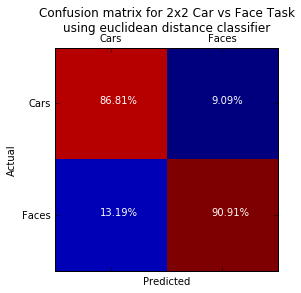

In [130]:
cmat_facevscar_mindist = get_confusion_matrix(predictions_facevscar_mindist, 
                                              categories[face_or_car], 
                                              ['Cars', 'Faces'])
visualize_confmat(cmat_facevscar_mindist, ['Cars', 'Faces'])
plt.title('Confusion matrix for 2x2 Car vs Face Task\nusing euclidean distance classifier')

#Upper right: True Positives
#Lower Right: True Negatives
#Upper Left: False Negatives
#Lower Left: False Positives

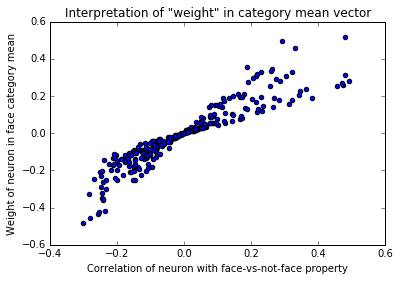

In [131]:
#actually we can interpret the relationship between these values
#and the single-neuron stuff we saw earlier .... 
plt.scatter(corr_facevsnot, category_means[4])
plt.xlabel('Correlation of neuron with face-vs-not-face property')
plt.ylabel('Weight of neuron in face category mean')
plt.title('Interpretation of "weight" in category mean vector')

#the value of the average response for neuron i in category j is highly correlated
#with the per-neuron correlation to the j-vs-not-j property

In [135]:
#But now we can do the same for 8-way classification
predictions_8way_mindist = np.array([distance_classifier(resp, 
                                                         category_means,
                                                         unique_categories)
                                   for resp in Neural_Data])

pct = fraction_correct(predictions_8way_mindist, categories)

print('Distance classifier accuracy on 8-way classification: %.2f%%' % (100*pct))

#this is way above chance -- recall, chance is 1/8 = 12.5% for this 8-way task

Distance classifier accuracy on 8-way classification: 48.78%


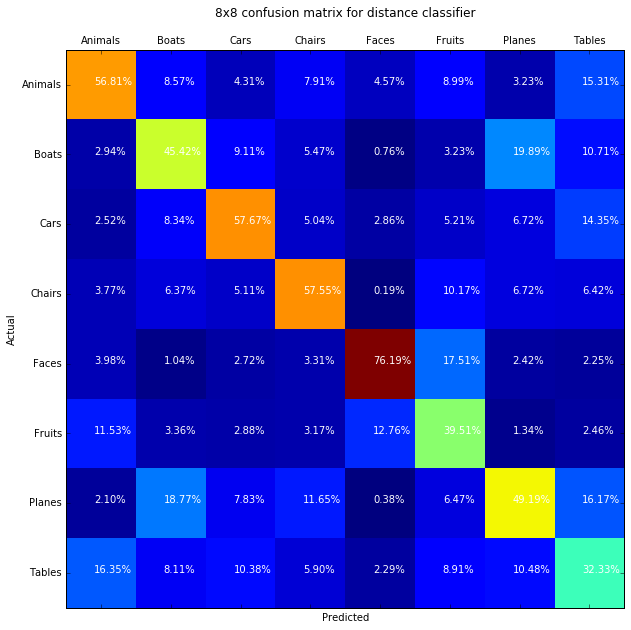

In [138]:
#let's have a look at the 8x8 confusion matrix
cmat_8way_mindist = get_confusion_matrix(predictions_8way_mindist, 
                                         categories, 
                                         unique_categories)
fig = plt.figure(figsize=(10, 10))
visualize_confmat(cmat_8way_mindist, unique_categories, fig=fig)
plt.title('8x8 confusion matrix for distance classifier')

In [239]:
dprime_confmat(cmat_8way_mindist)

array([1.42566505, 1.43142829, 1.62382391, 1.70692938, 2.10308049,
       1.53957159, 1.11902926, 0.94510888])

In [241]:
dprime_confmat(cmat_8way_mindist).mean()

1.4868296062774715

## Maximum Correlation classifiers

In [139]:
def correlation_classifier(x, means, ucats):
    """Arguments:
         x = new example of data -- of shape N (where N = number of neurons)
         means = matrix of means of each neuron for each category, 
                 of shape (M, N), where M = number of categories
         ucats = vector of category labels (of length M)
       Returns: prediction for x based on maximum correlation with category means
    """
    #get the correlations
    correlations = [stats.pearsonr(x, m)[0] for m in means]
    #find the index with highest correlation
    predicted_category_ind = np.argmax(correlations)
    #get the category with that index
    predicted_category = ucats[predicted_category_ind]
    return predicted_category

In [142]:
#let's test our correlation classifier on the same car/face binary classification from above
predictions_facevscar_maxcorr = [correlation_classifier(resp, 
                                                        carface_category_means,
                                                        ['Cars', 'Faces'])
                        for resp in Neural_Data_subset]
pct = fraction_correct(predictions_facevscar_maxcorr, categories[face_or_car])

print('Correlation classifier accuracy on Cars / Faces: %.2f%%' % (100*pct))

#ok, so this population classifier is in turn slightly better than the distance
#classifier (which was ~91%)


Correlation classifier accuracy on Cars / Faces (V0/V3): 89.17%


In [243]:
#And now, our correlation classifier on the 8-way task
predictions_8way_maxcorr = np.array([correlation_classifier(resp, 
                                                            category_means, 
                                                            unique_categories)
                                     for resp in Neural_Data])
pct = fraction_correct(predictions_8way_maxcorr, categories)

print('Correlation classifier accuracy on 8-way classification: %.2f%%' % (100*pct))

#again, somewhat better than the distance classifier (48%) ... but a bit slow!

Correlation classifier accuracy on 8-way classification: 53.04%


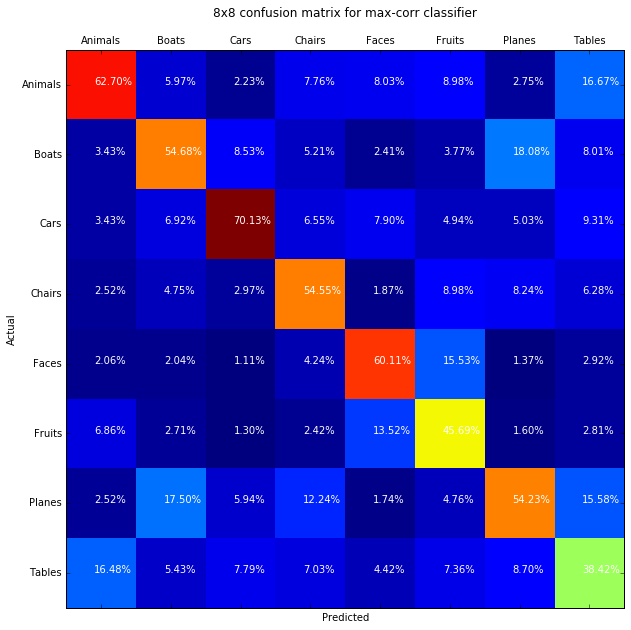

In [247]:
cmat_8way_maxcorr = get_confusion_matrix(predictions_8way_maxcorr, 
                                         categories, 
                                         unique_categories)
fig = plt.figure(figsize=(10, 10))
visualize_confmat(cmat_8way_maxcorr, unique_categories, fig=fig)
plt.title('8x8 confusion matrix for max-corr classifier')

In [248]:
dprime_confmat(cmat_8way_maxcorr).mean()

1.6222895582972898

In [144]:
def norm(data):
    """perform a whitening-like normalization operation on the data, feature-wise
       Assumes data = (K, M) matrix where K = number of stimuli and M = number of features
    """
    data = data - data.mean(0)  #subtract the feature-wise mean of the data
    data = data / np.maximum(data.std(0), 1e-5)  #divide by the feature-wise std of the data
    return data

Neural_Data_normed = norm(Neural_Data) #normed over all V0-V3 images

In [145]:
#See, the means are essentially 0.0 (up to numerical noise)
print('Means:', Neural_Data_normed.mean(0)[:10])
#and the stds are essentially 1.0 (up to numerical noise)
print('Stds:', Neural_Data_normed.std(0)[:10])

('Means:', array([-8.5060794e-09,  3.8743018e-08, -8.0507663e-09, -7.7982740e-08,
       -4.6307427e-08,  6.1720819e-08, -4.9158309e-08,  3.5646373e-08,
        3.8515363e-08, -1.9744039e-08], dtype=float32))
('Stds:', array([1.0000008 , 1.0000004 , 0.9999996 , 1.0000001 , 1.0000011 ,
       1.0000021 , 0.99999815, 1.0000001 , 1.0000006 , 1.0000008 ],
      dtype=float32))


In [146]:
category_means_normed = np.array([Neural_Data_normed[categories == c].mean(0) 
                                  for c in unique_categories])

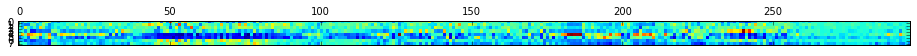

In [147]:
#the patterns look starker here than they did in the un-normed case
plt.matshow(category_means_normed)

In [148]:
prediction_8way_maxcorrnormed = [correlation_classifier(resp, 
                                     category_means_normed, 
                                     unique_categories)
                          for resp in Neural_Data_normed]

pct = fraction_correct(prediction_8way_maxcorrnormed, categories)
print('Normed Correlation classifier accuracy on 8-way classification'
      ': %.2f%%' % (100*pct))

#... and in fact, norming seems to help a little (compared to ~53% from un-normed case)

Normed Correlation classifier accuracy on 8-way classification: 56.37%


In [149]:
#This is a faster and more general version of all the distance-based classifiers
# ... this relies on the "cdist" function from scipy.spatial.distance:
#        https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html
#Not only is this code much faster than above, it also covers both the euclidean AND the 
#correlation cases... and potentially others too if you want to try them

from scipy.spatial.distance import cdist
def minimum_distance_classifier_fast(X, means, ucats, metric='euclidean'):
    """Arguments:
         X = array of examples of data -- of shape (K, N) where K = number of examples
             and N = number of neurons
         means = matrix of means of each neuron for each category, 
                 of shape (M, N), where M = number of categories
         ucats = vector of category labels (of length M)
         metric = which metric to compute based on (possibilities are described in)
             https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html#scipy.spatial.distance.cdist
       Returns: prediction for x based on minimum distance to category means for 
                requested meric
    """
    #use the cdist function to get a (K, M) distance matrix, with one row for each stimulus
    #  and one column for each category
    dists = cdist(X, means, metric=metric) #<-- this matrix is (K, M) in shape
    #get the length-K vector of indices of minimum-distance categories
    min_dist_inds = dists.argmin(axis=1)   #<-- this is a length-K vector of integers
    #return the category predictions
    return ucats[min_dist_inds]

In [151]:
#ok let's test the new classifier 

predictions_8way_maxcorrnormed = minimum_distance_classifier_fast(Neural_Data_normed, 
                                      category_means_normed, 
                                      unique_categories,
                                      metric='correlation')

pct = fraction_correct(predictions_8way_maxcorrnormed, categories)
print('Normed Correlation classifier accuracy on 8-way classification'
      ': %.2f%%' % (100*pct))

#see same result as before, but much faster!

Normed Correlation classifier accuracy on 8-way classification: 56.37%


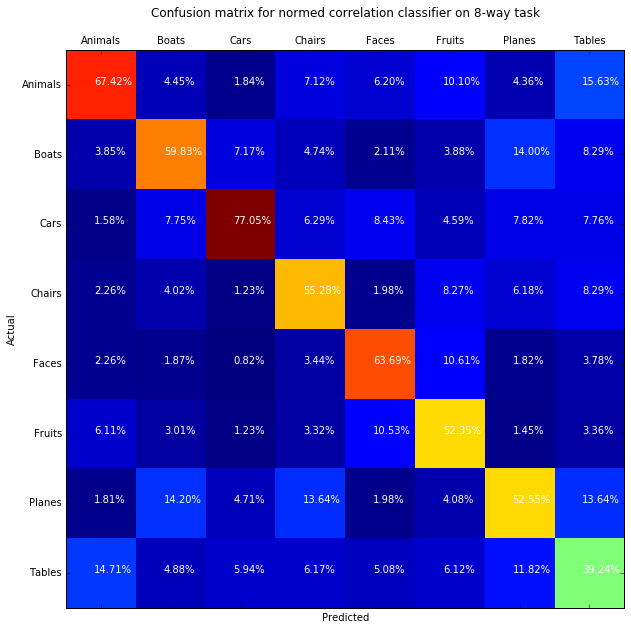

In [155]:
cmat_8way_maxcorrnormed = get_confusion_matrix(predictions_8way_maxcorrnormed, 
                            categories, 
                            unique_categories)
fig = plt.figure(figsize=(10, 10))
visualize_confmat(cmat_8way_maxcorrnormed, unique_categories, fig=fig)
plt.title('Confusion matrix for normed correlation classifier on 8-way task')

In [249]:
dprime_confmat(cmat_8way_maxcorrnormed).mean()

1.7513055836110794

### Simple RDM / Classifier comparison


In [158]:
objects = Ventral_Dataset['image_meta']['object_name'][:]   #array of object labels for all images --> shape == (5670,)
unique_objects = np.unique(objects)                      #array of unique object labels --> shape == (64,) 

objects_by_category = {c: np.unique(objects[categories == c]) 
                       for c in unique_categories}


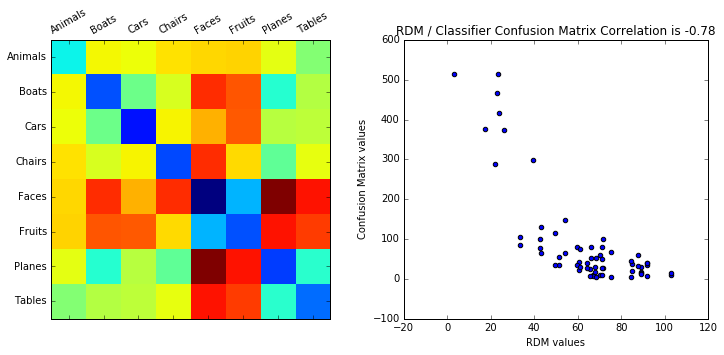

In [159]:
#It's interesting to compare the results from these classifiers to 
#RDMs generated by the underlying features
#so let's get the object-wise RDM for the data condition used to make the confusion matrix above (var0 and var3)
object_means_by_category = np.row_stack([[Neural_Data[(objects == o)].mean(0) 
                                                                for o in objects_by_category[c]]
                                                                for c in unique_categories])
rdm_object_means_by_category = 1 - np.corrcoef(object_means_by_category)

#this object-wise RDM is 64x64, but we want to comapre to an 8x8 confusion matrix
#so let's collapse the RDM grouping objects within category and then compre
collapsed = np.array([[rdm_object_means_by_category[8*i:8*(i+1), 8*j:8*(j+1)].sum()
                       for j in range(8)] for i in range(8)])

fig = plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
fig.gca().matshow(collapsed)
plt.xticks(range(8), unique_categories, rotation=30)
plt.yticks(range(8), unique_categories)
plt.subplot(1, 2, 2)
plt.scatter(collapsed.ravel(), cmat.ravel())
corrval = stats.pearsonr(collapsed.ravel(), cmat.ravel())[0]
plt.xlabel('RDM values')
plt.ylabel('Confusion Matrix values')
plt.title('RDM / Classifier Confusion Matrix Correlation is %.2f' % corrval)

#ok, the collapsed RDM elements correlate pretty well with the confusion matrix
#.... btw the correlation is expected to be negative since the RDM is a "dissimilarity" matrix

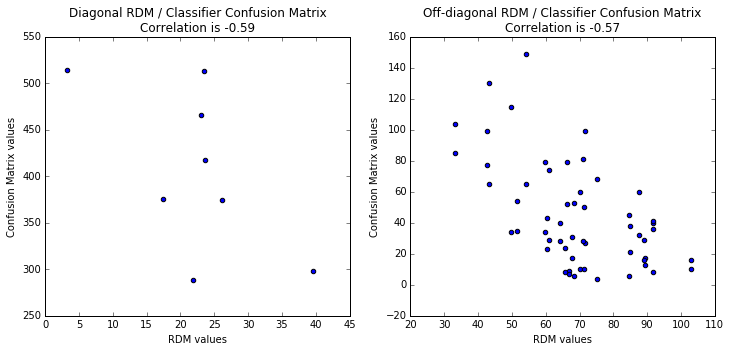

In [160]:
#but this is a little unfair, since we're looking at both diagonal and off diagonal elements simultaneously
#let's separate them

fig = plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
diagonal_rdm = collapsed.diagonal()
diagonal_confmat = cmat.diagonal()
plt.scatter(diagonal_rdm, diagonal_confmat)
corrval = stats.pearsonr(diagonal_rdm, diagonal_confmat)[0]
plt.xlabel('RDM values')
plt.ylabel('Confusion Matrix values')
plt.title('Diagonal RDM / Classifier Confusion Matrix\nCorrelation is %.2f' % corrval)

plt.subplot(1, 2, 2)
inds0, inds1 = np.triu_indices(8, 1)
inds2, inds3 = np.tril_indices(8, -1)
off_diagonal_rdm = np.concatenate([collapsed[inds0, inds1], collapsed[inds2, inds3]])
off_diagonal_confmat = np.concatenate([cmat[inds0, inds1], cmat[inds2, inds3]])
plt.scatter(off_diagonal_rdm, off_diagonal_confmat)
corrval = stats.pearsonr(off_diagonal_rdm, off_diagonal_confmat)[0]
plt.xlabel('RDM values')
plt.ylabel('Confusion Matrix values')
plt.title('Off-diagonal RDM / Classifier Confusion Matrix\nCorrelation is %.2f' % corrval)

#both are a bit lower than the all-values comparison but still not bad

### Comparison of  V4 and IT

In [162]:
IT_NEURONS = Ventral_Dataset['neural_meta']['IT_NEURONS']
V4_NEURONS = Ventral_Dataset['neural_meta']['V4_NEURONS']

In [163]:
#let's get some data
IT_Neural_Data_normed = Neural_Data_normed[:, IT_NEURONS]
V4_Neural_Data_normed = Neural_Data_normed[:, V4_NEURONS]

category_means_normed_IT = category_means_normed[:, IT_NEURONS]
category_means_normed_V4 = category_means_normed[:, V4_NEURONS]

In [165]:
#Ok, how does the performance go if we only look at IT neurons?
predictions_8way_maxcorrnormed_IT = minimum_distance_classifier_fast(IT_Neural_Data_normed, 
                                      category_means_normed_IT, 
                                      unique_categories,
                                      metric='correlation')

pct = fraction_correct(predictions_8way_maxcorrnormed_IT, categories)
print('Normed Correlation classifier accuracy from IT on 8-way classification'
      ': %.2f%%' % (100*pct))

#so compared to having all 296 neurons, almost no performance drop just by looking at IT

Normed Correlation classifier accuracy from IT on 8-way classification: 57.60%


In [166]:
#what about V4 neurons only?
predictions_8way_maxcorrnormed_V4 = minimum_distance_classifier_fast(V4_Neural_Data_normed, 
                                      category_means_normed_V4, 
                                      unique_categories,
                                      metric='correlation')

pct = fraction_correct(predictions_8way_maxcorrnormed_V4, categories)
print('Normed Correlation classifier accuracy from V4 on 8-way classification'
      ': %.2f%%' % (100*pct))

#however, looking only at V4 neurons does lead to an apparently substantial performance drop

Normed Correlation classifier accuracy from V4 on 8-way classification: 32.78%


In [170]:
#actually, to be fair in our comparison of IT to V4 we need to equalize the number of 
#neurons on which we build the classifiers.  There are more IT neurons in the dataset (168)
#than there are V4 neurons (128).  So let's subsample 128 IT neurons. 
#Of course, to do this properly we should subsample a bunch of times. 

fair_number_of_neurons = min(len(IT_NEURONS), len(V4_NEURONS))

def subsample_IT_and_check_performance(K):
    rng = np.random.RandomState(seed=0)
    pcts = []
    for sample_num in range(K):
        perm = rng.permutation(len(IT_NEURONS))
        IT_Neural_Data_normed_subsample = IT_Neural_Data_normed[:, 
                                                        perm[:fair_number_of_neurons]]
        category_means_normed_IT_subsample = category_means_normed_IT[:, 
                                                        perm[:fair_number_of_neurons]]

        predictions = minimum_distance_classifier_fast(IT_Neural_Data_normed_subsample, 
                                              category_means_normed_IT_subsample, 
                                              unique_categories,
                                              metric='correlation')

        pct = fraction_correct(predictions, categories)
        pcts.append(pct)
    return pcts
        
#let's do the subsampling 100 times (it's a good thing we have a fast classifier!)
pcts = subsample_IT_and_check_performance(100)
    
print('Normed Correlation classifier accuracy from %d-neuron IT subsample on '
      '8-way classification: %.2f%% (mean) %.2f%% (std)' % (fair_number_of_neurons, 
                                                100*np.mean(pcts),
                                                100*np.std(pcts)))

#ok, so still way better than 128 V4 neurons -- so the performance improvement in IT is probably NOT because there are more IT neurons
#in the sample.

Normed Correlation classifier accuracy from 128-neuron IT subsample on 8-way classification: 56.56% (mean) 0.72% (std)


In [171]:
#let's look at where the weights come from in the classifier
def weightfunc(x):
    return (x - x.mean(1)[:, np.newaxis]) / (x.std(1)[:, np.newaxis])

abs_weights = np.abs(weightfunc(category_means_normed))

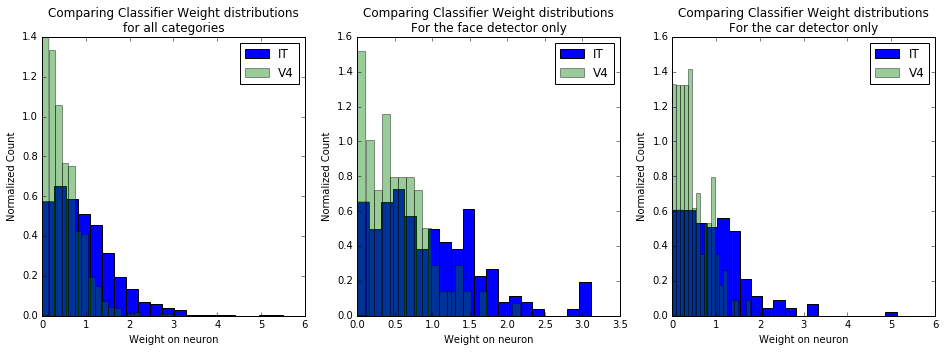

In [172]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
l0 = plt.hist(abs_weights[:, IT_NEURONS].ravel(), bins=20, normed=True)
l1 = plt.hist(abs_weights[:, V4_NEURONS].ravel(), bins=20, normed=True, alpha=.4)
plt.legend([l0[2][0], l1[2][0]], ['IT', 'V4'])
plt.title('Comparing Classifier Weight distributions\nfor all categories')
plt.xlabel('Weight on neuron')
plt.ylabel('Normalized Count')

plt.subplot(1, 3, 2)
l0 = plt.hist(abs_weights[:, IT_NEURONS][4], bins=20, normed=True)
l1 = plt.hist(abs_weights[:, V4_NEURONS][4], bins=20, normed=True, alpha=.4)
plt.legend([l0[2][0], l1[2][0]], ['IT', 'V4'])
plt.title('Comparing Classifier Weight distributions\nFor the face detector only')
plt.xlabel('Weight on neuron')
plt.ylabel('Normalized Count')

plt.subplot(1, 3, 3)
l0 = plt.hist(abs_weights[:, IT_NEURONS][2], bins=20, normed=True)
l1 = plt.hist(abs_weights[:, V4_NEURONS][2], bins=20, normed=True, alpha=.4)
plt.legend([l0[2][0], l1[2][0]], ['IT', 'V4'])
plt.title('Comparing Classifier Weight distributions\nFor the car detector only')
plt.xlabel('Weight on neuron')
plt.ylabel('Normalized Count')

#so IT units are substantially heigher weighted by the classifier

## Getting Splits for Cross Validation

In [173]:
def get_splits(metadata,
               split_by_func,
               num_splits,
               num_per_class_test,
               num_per_class_train,
               train_filter=None,
               test_filter=None,
               seed=0):
    """
    construct a consistent set of splits for cross validation
    
    arguments: 
        metadata: numpy.rec.array of metadata 
        split_by_func: callable, returns label for spliting data into balanced categories 
                       when applied to metadata
        num_per_class_test: number of testing examples for each unique split_by category
        num_per_class_train: number of train examples for each unique split_by category
        train_filter: callable (or None): specifying which subset of the data to use in training
                       applied on a per-element basis to metadata
        test_filter: callable (or None): specifying which subset of the data to use in testing
                       applied on a per-element basis to metadata
        seed: seed for random number generator
    """
    
    #define helper function for filtering metadata by desired filter
    def get_possible_inds(metadata, filter):
        inds = np.arange(len(metadata))
        if filter is not None:
            subset = np.array(map(filter, metadata)).astype(np.bool)
            inds = inds[subset]
        return inds
    
    #filter the data by train and test filters
    train_inds = get_possible_inds(metadata, train_filter)
    test_inds = get_possible_inds(metadata, test_filter)
    
    #construct possibly category labels for balancing data
    labels = split_by_func(metadata)
    #for later convenience, get unique values of splitting labels in train and test data
    unique_train_labels = np.unique(labels[train_inds])
    unique_test_labels = np.unique(labels[test_inds])
    
    #seed the random number generator
    rng = np.random.RandomState(seed=seed)
    
    #construct the splits one by one
    splits = []
    for _split_ind in range(num_splits):
        #first construct the testing data
        actual_test_inds = []
        #for each possible test label
        for label in unique_test_labels: 
            #look at all possible stimuli with this label
            possible_test_inds_this_label = test_inds[labels[test_inds] == label]
            #count how many there are
            num_possible_test_inds_this_label = len(possible_test_inds_this_label)
            #make sure there are enough
            assert num_possible_test_inds_this_label >= num_per_class_test, 'You requested %s per test class but there are only %d available' % (num_per_class_test,
                                                                                      num_possible_test_inds_this_label)
            #select num_per_class_test random examples
            perm = rng.permutation(num_possible_test_inds_this_label)
            actual_test_inds_this_label = possible_test_inds_this_label[perm[ :num_per_class_test]]
            actual_test_inds.extend(actual_test_inds_this_label)
        actual_test_inds = np.sort(actual_test_inds)
        
        #now, since the pools of possible train and test data overlap, 
        #but since we don't want the actual train and data examples to overlap at all,
        #remove the chosen test examples for this split from the pool of possible train examples for this split
        remaining_available_train_inds = np.unique(list(set(train_inds).difference(actual_test_inds)))
        
        #now contruct the train portion of the split
        #basically the same way as for the testing examples
        actual_train_inds = []
        for label in unique_train_labels:
            _this_label = labels[remaining_available_train_inds] == label
            possible_train_inds_this_label = remaining_available_train_inds[_this_label]
            num_possible_train_inds_this_label = len(possible_train_inds_this_label)
            assert num_possible_train_inds_this_label >= num_per_class_train, 'You requested %s per train class but there are only %d available' % (num_per_class_train,
                                                                                       num_possible_train_inds_this_label)
            perm = rng.permutation(num_possible_train_inds_this_label)
            actual_train_inds_this_label = possible_train_inds_this_label[perm[ :num_per_class_train]]
            actual_train_inds.extend(actual_train_inds_this_label)
        actual_train_inds = np.sort(actual_train_inds)
        
        split = {'train': actual_train_inds, 'test': actual_test_inds}
        splits.append(split)
        
    return splits
        
    

In [174]:
#use numpy recarray object to store metadata 
meta_array = np.core.records.fromarrays(Ventral_Dataset['image_meta'].values(),
                                        names=Ventral_Dataset['image_meta'].keys())

meta_array.dtype

dtype((numpy.record, [(u'category', 'S7'), (u'image_id', 'S40'), (u'object_name', 'S24'), (u'rotation_xy', '<f8'), (u'rotation_xz', '<f8'), (u'rotation_yz', '<f8'), (u'size', '<f8'), (u'translation_y', '<f8'), (u'translation_z', '<f8'), (u'variation_level', 'S2')]))

In [175]:
np.unique(meta_array['object_name']).shape

(64,)

In [176]:
def my_named_func(x):
    return 2 * x

In [177]:
my_named_func(2)

4

In [178]:
g = lambda x: 2 * x

g(2)

4

In [179]:
splits = get_splits(metadata=meta_array, 
                    split_by_func=lambda x: x['object_name'],  #we're balancing splits by object
                    num_splits=10,  #10 total splits
                    num_per_class_test=10,  #with 10 testing 
                    num_per_class_train=40,  #and 40 training examples per object
                    train_filter=lambda x: x['variation_level'] in ['V3', 'V6'], #keeping only V3 and V6 stimuli in training
                    test_filter=lambda x: x['variation_level'] in ['V0'], #testing only on V0 stimuli
                   )

In [180]:
#there should be 10 splits
len(splits)
#ok

10

In [181]:
#each split should have train and test components
splits[2].keys()
#ok

['test', 'train']

In [182]:
splits[2]['train']

array([ 640,  642,  644, ..., 5755, 5757, 5759])

In [183]:
#each training split should have 40 * 64 = 2560 images
splits[0]['train'].shape
#ok

(2560,)

In [184]:
#each testing split should have 10 * 64 = 640 images
splits[2]['test'].shape
#ok

(640,)

In [185]:
#only variation V3 and V6 images should appear in training data
train_meta = meta_array[splits[0]['train']]
np.unique(train_meta['variation_level'])
#ok

array(['V3', 'V6'], dtype='|S2')

In [186]:
#only variation V0 images should appear in testing data
test_meta = meta_array[splits[0]['test']]
np.unique(test_meta['variation_level'])
#ok

array(['V0'], dtype='|S2')

In [187]:
splits = get_splits(meta_array, 
                    lambda x: x['object_name'],  #we're balancing splits by object
                    10,  #10 total splits
                    100,  #with 100 testing 
                    40,  #and 40 training examples per object
                    train_filter=lambda x: x['variation_level'] in ['V3', 'V6'], #keeping on V3 and V6 stimuli in training
                    test_filter=lambda x: x['variation_level'] in ['V0'], #testing on V0 stimuli
                   )
#error since asked for too many testing images per class

AssertionError: You requested 100 per test class but there are only 10 available

In [188]:
splits = get_splits(meta_array, 
                    lambda x: x['object_name'],  #we're balancing splits by object
                    10,  #10 total splits
                    50,  #with 50 testing 
                    50,  #and 50 training examples per object
                    train_filter=lambda x: x['variation_level'] in ['V3', 'V6'], #keeping on V3 and V6 stimuli in training
                    test_filter=lambda x: x['variation_level'] in ['V3', 'V6'], #also testing on V3 and V6
                   )
#again, too many testing images per class since there are only 80 total V3 and V6 
#... and the training/testing splits cannot overlap

AssertionError: You requested 50 per train class but there are only 30 available

In [189]:
splits = get_splits(meta_array, 
                    lambda x: x['object_name'],  #we're balancing splits by object
                    10,  #10 total splits
                    40,  #with 40 testing 
                    40,  #and 40 training examples per object
                    train_filter=lambda x: x['variation_level'] in ['V3', 'V6'], #keeping on V3 and V6 stimuli in training
                    test_filter=lambda x: x['variation_level'] in ['V3', 'V6'], #also testing on V3 and V6
                   )
#ok this time we're fine

In [190]:
#each training and testing split should have 40 * 64 = 2560 images
print(splits[0]['train'].shape, 
      splits[0]['test'].shape)
#ok

((2560,), (2560,))


In [191]:
#training and testing splits better not overlap
set(splits[0]['train']).intersection(splits[0]['test'])
#... phew

set()

In [192]:
splits = get_splits(meta_array, 
                    lambda x: x['category'],  #we're balancing splits by category now
                    10,  #10 total splits
                    160,  #with 160 testing 
                    160,  #and 160 training examples per category
                    train_filter=lambda x: x['variation_level'] in ['V3', 'V6'], #keeping on V3 and V6 stimuli in training
                    test_filter=lambda x: x['variation_level'] in ['V3', 'V6'], #also testing on V3 and V6
                   )

#we might not have balance across objects any more, since we split by category

In [193]:
#just a weird example to show flexibility:
#split by 10 bins (in each dimension) of position value 

def translation_binifier(x):
    y = x['translation_y']
    y1 = y - y.min()
    y2 = y1 / y1.max()
    N = 10
    ybin = np.round(y2 * N).astype(np.int).astype(str)

    z = x['translation_z']
    z1 = z - z.min()
    z2 = z1 / z1.max()
    N = 10
    zbin = np.round(z2 * N).astype(np.int).astype(str)
    
    yzbin = np.array([a + '_' + b for (a,b) in zip(ybin, zbin)])
    return yzbin
    
splits = get_splits(meta_array, 
                    translation_binifier,
                    10,  #10 total splits
                    2,  #with 2 testing 
                    5,  #and 6 training examples per position bin
                    train_filter=lambda x: -.4 < x['translation_y'] < .4, #keeping on V3 and V6 stimuli in training
                    test_filter=lambda x: -.4 < x['translation_y'] < .4, #also testing on V3 and V6
                   )



## The Train-Test Procedure

In [195]:
class MinimumDistanceClassifier(object):
    """
    Codification of generic minimum distance classifier in a scikit-learn friendly format.
    """
    def __init__(self, labelset, n_features, fnorm=False, metric='correlation'):
        """
        Arguments: 
            labelset -- list of unique values the classifier can have
            n_features -- how many features will be trained/tested
            fnorm -- whether to do featurewise normalization or not
            metric -- what distance metric to use (consistent with scipy.spatial.distance.cdist)
        """
        assert labelset.ndim == 1, 'The labelset can only have one dimension'
        assert len(labelset) == len(np.unique(labelset)), 'The labelset must be a unique list of elements'
        self.labelset = labelset
        self.n_classes = len(labelset)
        self.n_features = n_features
        self.fnorm = fnorm
        self.metric = metric

    def initialize(self, val=None, n=None):
        self._mu = np.zeros((self.n_classes, self.n_features))
        self._n_samples = np.zeros((self.n_classes,)).astype(np.int)
        if val is not None:
            assert val.shape == self.mu.shape
            assert n.dtype == self._n_samples.dtype
            assert n.shape == self._n_samples.shape
            assert (n >= 0).all()
            self._mu += val
            self._n_samples += n

    def fit(self, X, y):
        """X = training features
           y = training labels
        """
        self.initialize(val=None, n=None)
        if self.fnorm:
            self.fmean = X.mean(axis=0)
            X = X - self.fmean
            self.fvar = X.std(axis=0)
            X = X / np.maximum(self.fvar, 1e-6)
        self.partial_fit(X, y)

    def partial_fit(self, X, y, safe=True):
        assert X.ndim == 2
        assert y.ndim == 1
        assert X.shape == (len(y), self.n_features), (X.shape, (len(y), self.n_features))
        assert set(y) <= set(self.labelset), (set(y), set(self.labelset))
        if safe:
            uy = np.unique(y)
            assert (uy == self.labelset).all()
        for vi, v in enumerate(self.labelset):
            Xv = X[y == v]
            nv = float(Xv.shape[0])
            if nv > 0:
                Xvm = Xv.mean(0)
                ns = self._n_samples[vi]
                self._mu[vi] = (ns / (ns + nv)) * self._mu[vi] + (nv / (ns + nv)) * Xvm
                self._n_samples[vi] += int(nv)

    @property
    def coef_(self):
        c = self._mu
        return c

    @property
    def weights(self):
        c = self.coef_
        def weightfunc(x):
            return (x - x.mean(1)[:, np.newaxis]) / (x.std(1)[:, np.newaxis])
        return weightfunc(c)

    def decision_function(self, X):
        if self.fnorm:
            X = X - self.fmean
            X = X / np.maximum(self.fvar, 1e-6)
        return cdist(X, self.coef_, metric=self.metric)

    def predict(self, X):
        assert X.ndim == 2
        assert X.shape[1] == self.n_features
        decs = self.decision_function(X)

        return self.labelset[decs.argmin(1)]

In [196]:
#"instantiating" an example of a MinimumDistanceClassifier
#and specifically ... a correlation classifier
model = MinimumDistanceClassifier(unique_categories,
                                  Neural_Data.shape[1],
                                  fnorm=True,
                                  metric='correlation')

In [197]:
model.n_features

296

In [198]:
model.metric

'correlation'

In [199]:
model.fit(Neural_Data, meta_array['category'])

In [200]:
model.coef_.shape

(8, 296)

In [201]:
def evaluate_results(confmats, labels):
    """Convenience function that summarize results over confusion matrices
       Arguments:
           confmats = array of shape (M, M, ns)  where M = number of categories
                      and ns = number of splits
                confmats[i, j, k] = number of times classifier predicted class j 
                                    when actual is class i, on split k 
           labels = length-M vector of category labels
           
       Returns: dictionary with useful summary metrics, including dprime,
                balanced accuracy, and percent correct (regular "accuracy")
                both for the split-mean confusion matrix, and separately across splits
                  
    """
    result = {}
    result['labels'] = labels
    result['confusion_matrices'] = confmats
    mean_confmat = confmats.mean(0)
    result['mean_dprime'] = dprime_confmat(mean_confmat)
    result['mean_balanced_accuracy'] = balanced_accuracy(mean_confmat)
    result['mean_accuracy'] = accuracy_confmat(mean_confmat)
    
    result['dprime_by_split'] = [dprime_confmat(c) for c in confmats]
    result['balanced_acc_by_split'] = [balanced_accuracy(c) for c in confmats]
    result['accuracy_by_split'] = [accuracy_confmat(c) for c in confmats]
    
    return result    
    
    
def train_and_test_correlation_classifier(features, labels, splits):
    """Routine for contructing, training and testing correlation classifier
       
       Arguments: 
           features: (K, M) feature array where K = number of stimuli and M = number of features
           labels: length-K vector of labels to be predicted
           splits: splits of data (constructed by calling the get_splits function)
           
       Returns:
           dictionary summary of training and testing results
    
    """
    ucats = np.unique(labels)
    train_confmats = []
    test_confmats = []
    for split in splits:
        #here we instantiate the MDC
        model = MinimumDistanceClassifier(ucats,
                                          features.shape[1],
                                          fnorm=True,
                                          metric='correlation')
        
        train_inds = split['train']
        test_inds = split['test']
        
        train_features = features[train_inds]
        train_labels = labels[train_inds]
        model.fit(train_features, train_labels)
        
        train_predictions = model.predict(train_features)
        train_confmat = get_confusion_matrix(train_predictions, train_labels, ucats)
        train_confmats.append(train_confmat)
        
        test_features = features[test_inds]
        test_labels = labels[test_inds]
        
        test_predictions = model.predict(test_features)
        test_confmat = get_confusion_matrix(test_predictions, test_labels, ucats)
        test_confmats.append(test_confmat)
        
    train_confmats = np.array(train_confmats)
    train_results = evaluate_results(train_confmats, ucats)
    test_confmats = np.array(test_confmats)
    test_results = evaluate_results(test_confmats, ucats)
    results = {'train': train_results, 'test': test_results}
    return results
        

In [202]:
#OK let's test out our new machinery 
V4_Neural_Data = Neural_Data[:, V4_NEURONS]
IT_Neural_Data = Neural_Data[:, IT_NEURONS]

splits = get_splits(meta_array, 
                    lambda x: x['object_name'],  #we're balancing splits by object
                    10,  #10 total splits
                    20,  #with 20 testing 
                    20,  #and 20 trainin examples per object
                    train_filter=lambda x: x['variation_level'] in ['V3', 'V6'], #keeping on V3 and V6 stimuli in training
                    test_filter=lambda x: x['variation_level'] in ['V3', 'V6'], #in testing too
                   )

results_V4 = train_and_test_correlation_classifier(V4_Neural_Data, meta_array['category'], splits)
results_IT = train_and_test_correlation_classifier(IT_Neural_Data, meta_array['category'], splits)

print('Average test accuracy of V4 on 8-way categorization (V3 & V6) is %.2f%%' % (100*results_V4['test']['mean_accuracy']))
print('Average test accuracy of IT on 8-way categorization (V3 & V6) is %.2f%%' % (100*results_IT['test']['mean_accuracy']))

Average test accuracy of V4 on 8-way categorization (V3 & V6) is 28.19%
Average test accuracy of IT on 8-way categorization (V3 & V6) is 55.04%


In [203]:
#Ok let's flex our muscles a little and compute a training curve as a function of 
#number of training examples

train_curve_points = [2, 5, 10, 15, 20, 30, 40, 50, 
                      60, 80, 160, 240, 320, 400, 480]
def get_category_training_curve(features):
    results = []
    for num_train in train_curve_points:
        splits = get_splits(meta_array, 
                    lambda x: x['category'], #now we're going to construct splits by *category* rather than object
                    20,  #20 splits each time
                    20 * 8,   #total of 20*8 = 160 testing examples per category
                    num_train,  #here's where the variable number of training examples comes in
                    train_filter=lambda x: x['variation_level'] in ['V3', 'V6'], #same filters as above
                    test_filter=lambda x: x['variation_level'] in ['V3', 'V6'])
        result = train_and_test_correlation_classifier(features, meta_array['category'], splits)
        results.append(result)
    return results

V4_curve = get_category_training_curve(V4_Neural_Data)
IT_curve = get_category_training_curve(IT_Neural_Data)

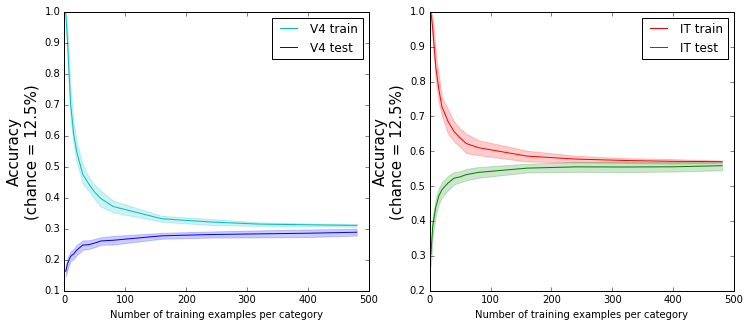

In [204]:
#Let's plot our results.
def plot_training_curve(curve_data, color1, color2):
    train_means = np.array([np.mean(r['train']['accuracy_by_split']) for r in curve_data])
    train_stds = np.array([np.std(r['train']['accuracy_by_split']) for r in curve_data])
    test_means = np.array([np.mean(r['test']['accuracy_by_split']) for r in curve_data])
    test_stds = np.array([np.std(r['test']['accuracy_by_split']) for r in curve_data])

    l1 = plt.plot(train_curve_points, train_means, color=color1)
    plt.fill_between(train_curve_points, 
                     train_means - train_stds, 
                     train_means + train_stds, 
                     color=color1,
                     alpha = 0.2)
    l2 = plt.plot(train_curve_points, test_means, color=color2)
    plt.fill_between(train_curve_points, 
                     test_means - test_stds, 
                     test_means + test_stds, 
                     color=color2,
                     alpha = 0.2)
    plt.xlabel('Number of training examples per category')
    plt.ylabel('Accuracy\n(chance = 12.5%)', fontsize=15)
    return l1, l2
    
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
l0, l1 = plot_training_curve(V4_curve, 'c', 'b')
plt.legend([l0[0], l1[0]], ['V4 train', 'V4 test'])
plt.subplot(1, 2, 2)
l2, l3 = plot_training_curve(IT_curve, 'r', 'g')
plt.legend([l2[0], l3[0]], ['IT train', 'IT test'])

#ok, we're seeing: several interesting things:
#   (1) both IT and V4 have fast-increasing training curves.  Don't need that many examples 
#       to approach final performace
#   (2) IT >> V4 -- we knew that already
#   (3) You can see the strong signs of overfitting with small numbers of training examples
#       ... that is, where train performance > test performance.  Increasing the number of
#       training examples both increases test performance, but *decreases* train performance
#       to the point where they meet (e.g. no overfitting is occuring)